# Training a YOLO model
___
Assuming miniconda3 was installed during the annotation step, let's set up a new environment, yolov8. The environment.yml file in this dir can be used to install the necessary packages. 

In a terminal navigate to this current directory and run the following:

<code>conda env create -f environment.yml</code>

Then select the yolov8 kernel for this notebook under 'Python environments'

In [2]:
from ultralytics import YOLO
import ultralytics
import os

os.environ['WANDB_DISABLED'] = 'true'

There are two config yamls in this dir, practice_dataset.yaml and config.yaml.

practice_dataset.yaml defines the data location. Pointing YOLO to your data can be frustrating because there is a settings.yaml file (e.g. in ~/.config/Ultralytics) that specifies a root 'datasets_dir' that may confuse the path in your dataset.yaml. If the dataset is not found when you try to train the model, the error will specify where you need to look for the settings.yaml file. 

config.yaml is where you set metadata for the training run and hyperparameters. The file has descriptions of each of the settings, but here are some important ones:
- **model**: choose which pretrained yolo model to fine-tune (yolov8n = nano, yolov8s = small, etc.). Smaller models will train faster, larger models take longer to train and run, but are suited for very complex detection tasks. 
- **data**: make sure it points to the right dataset.yaml (practice_dataset.yaml in our case)
- **epochs**: One epoch is one train/val pass on the whole dataset. Start with just a few epochs (10) to troubleshoot your dataset/hyperparameter configuration, then train on 100-200 epochs when you have your settings dialed in
- **batch**: with a single GPU, Autobatch (-1) is great so you can set different img sizes and it'll adjust to the GPU available. Autobatch isn't available when you're training in parallel on multiple GPUs (afaik). The larger the batch size, the better - the algorith is 'learning' on more information each step. Your batch size will be limited by your GPU VRAM availability. 
- **imgsz**: imgs can be resized for more efficient training (imgsz: 640 resizes each img to 640x640). Smaller images mean more images per batch, but if the details we want to detect are small (flies, etc.), shrinking the size can obscure necessary details.
- **device**: useful if working with multiple GPUs or on a cluster
- **project**: name your project to keep it organized, especially if exporting results to WandB
- **optimizer**: you may want to specify SGD or one of the Adams based on the application, or experiment between several
- **close mosaic**: we'll get into the mosaic augmentation later, worth noting this setting
- **iou**: set the intersection over union threshold for Non-max Suppression (NMS). Decrease this if youre getting a lot of boxes duplicated over the same object. 

### Hyperparameters and Augmentations
Augmentations can be randomly applied to images during training to simulate image variation in real conditions (light source, different lenses, time of day, etc.). Augmenting images can make the model more robust to new data, but only use augmentations that make sense, e.g. don't vary the hue wildly if object color is important in classfying the object (fine if just detecting).
- **lr0 and lrf**: initial and final learning rates. important to experiment with if not automated
- **hsv_h, hsv_s, hsv_v**: vary the hue, saturation, and value (brightness) randomly by the percentage provided
- **scale, flipud, fliplr**: scale can be useful to account for changes in object size, flipping works well in the case of the fly or camera trap imgs because they are top-down (it wouldn't make sense to flipud an img of a giraffe).
- **mosaic**: a useful augmentation that makes a composite from the corners of 4 random images in the batch. This works well to shuffle the data even more during training and accommodate variation in unseen data.

Familiarize yourself with all the settings and consider their applicability to the dataset you're working on. 

In [2]:
cfg = ultralytics.cfg.get_cfg(cfg='config.yaml') # Load in cfg
model = YOLO("yolov8n.pt") # Load pretrained model. It will download if it's not directly available

The following code trains the model. You'll likely have to adjust the root dataset path in the .config/Ultralytics/settings.yaml file to 

In [5]:
results = model.train(cfg='config.yaml') # run training

New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_boxes' instead.
Ultralytics YOLOv8.2.35 🚀 Python-3.11.5 torch-2.0.1 CUDA:0 (NVIDIA RTX A4500, 20156MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=practice_dataset.yaml, epochs=10, time=None, patience=50, batch=-1, imgsz=1088, save=True, save_period=-1, cache=False, device=None, workers=8, project=practice_runs, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=2, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=None, iou=0.6, max_det=100, half=False, dnn=False, plots=True, source=None, vid_stride=

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


/home/mpgetz/miniconda3/envs/yolov8/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=1088 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA RTX A4500) 19.68G total, 0.23G reserved, 0.07G allocated, 19.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011043       23.68         0.564         4.917         23.66      (1, 3, 1088, 1088)                    list
     3011043       47.36         0.946         6.152         16.22      (2, 3, 1088, 1088)                    list
     3011043       94.72         1.583         11.61         20.27      (4, 3, 1088, 1088)                    list
     3011043       189.4         2.890         20.89         30.25      (8, 3, 1088, 1088)                    list
     3011043       378.9         5.736          41.9         53.69     (16, 3, 1088, 1088)                    list
AutoBatch: Using batch-size 33 for CUDA:0 11.83G/19.68G (60%) ✅


train: Scanning /home/mpgetz/repos/cv_bootcamp/2_DATASET/practice_dataset/train.cache... 300 images, 45 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
val: Scanning /home/mpgetz/repos/cv_bootcamp/2_DATASET/practice_dataset/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]


Plotting labels to practice_runs/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000515625), 63 bias(decay=0.0)
Image sizes 1088 train, 1088 val
Using 8 dataloader workers
Logging results to practice_runs/train12
Starting training for 10 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      12.7G      1.902       8.15      1.548          5       1088: 100%|██████████| 10/10 [00:32<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         60         61     0.0055      0.541      0.338      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      12.7G      1.687      6.022      1.307          4       1088: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         60         61     0.0055      0.541      0.414      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      12.7G      1.374      3.833      1.106          7       1088: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         60         61     0.0035      0.344      0.091     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      12.7G      1.352      3.368      1.094          6       1088: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


                   all         60         61    0.00583      0.574     0.0902     0.0395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      12.7G       1.26      3.839      1.049          1       1088: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         60         61     0.0587      0.705      0.632      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      12.7G      1.306      2.947      1.083          4       1088: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         60         61          1      0.388      0.756      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      12.7G      1.225      2.716       1.06          4       1088: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         60         61      0.962      0.623      0.932      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      12.7G      1.103      2.365      1.004          4       1088: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


                   all         60         61      0.951      0.639      0.885      0.547
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.7G      1.144      2.762     0.9697          3       1088: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         60         61      0.982      0.889      0.941      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      12.7G      1.085      2.573     0.9587          5       1088: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         60         61          1      0.899      0.954      0.646



10 epochs completed in 0.026 hours.
Optimizer stripped from practice_runs/train12/weights/last.pt, 6.3MB
Optimizer stripped from practice_runs/train12/weights/best.pt, 6.3MB

Validating practice_runs/train12/weights/best.pt...
Ultralytics YOLOv8.2.35 🚀 Python-3.11.5 torch-2.0.1 CUDA:0 (NVIDIA RTX A4500, 20156MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


                   all         60         61          1      0.898      0.954      0.648
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving practice_runs/train12/predictions.json...
Results saved to practice_runs/train12


lr/pg0,▁▃▅▇███▇▆▄
lr/pg1,▁▃▅▇███▇▆▄
lr/pg2,▁▃▅▇███▇▆▄
metrics/mAP50(B),▃▄▁▁▅▆█▇██
metrics/mAP50-95(B),▃▂▁▁▅▆█▇██
metrics/precision(B),▁▁▁▁▁█████
metrics/recall(B),▃▃▁▄▆▂▅▅██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▃▃▃▃▂▁▂▁


The training metrics look pretty good, but go into the output dir (practice_runs/train#). The output dir contains the weights and metrics reports. Look through all the metric reports and get a sense for where the model is struggling.

The train_batch#.jpg and val_batch#_pred.jpg imgs are useful to see what the model is being trained on and get a small snapshot of how the model is doing on the val set. By comparing the val_labels and val_pred jpgs, we can see that very few insects in the val set are being detected. The Recall-confidence curve (R_curve) is also very poor, and the confusion_matrix shows that few insects are being detected. 

What does it mean when the training metrics are high but the validation performance is low?
___

We can apply our trained model to new images now. If your model isn't already defined (as it is during training above), you can load any model from the output weights:

In [ ]:
model = YOLO('practice_runs/train/weights/best.pt')

Then we can use the model to run inference on a new image. This image happens to work:


0: 640x1088 1 insect, 45.6ms
Speed: 5.0ms preprocess, 45.6ms inference, 46.4ms postprocess per image at shape (1, 3, 640, 1088)


/home/mpgetz/miniconda3/envs/yolov8/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


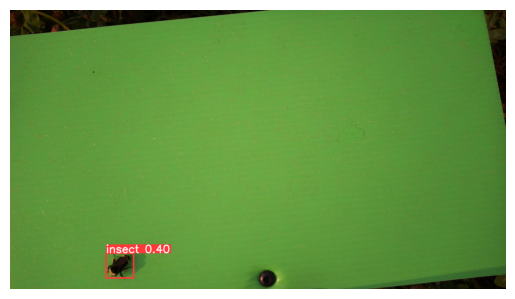

In [4]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# load in img
image_path = "../1_ANNOTATION/jpgs_to_annot/pi1_20240721_091114.jpg" 
image = cv2.imread(image_path)

# run model on image
results = model(image)

# plot results
for r in results:
        im_array = r.plot()
        im = Image.fromarray(im_array[..., ::-1]) 
        plt.imshow(im)
plt.axis("off")
plt.show()